In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# Loading data

In [2]:
topics = {
    0: 'News',
    1: 'Sport',
    2: 'Business',
    3: 'Tech',
    4: 'Health & Fitness',
    5: 'Money',
    6: 'Opinion',
}

geographies = {
    0: 'Region A',
    1: 'Region B',
    2: 'Region C',
    3: 'Region D',
    4: 'Region E',
    5: 'Region F'
}

In [3]:
df = pd.read_pickle("df.pickle")

In [4]:
df.head()

,id,geography,current_topic,visit_count_30_days,most_favorite_topic,least_favorite_topic,topic_shown
0,0,1,News,6,News,Tech,News
1,1,0,News,64,News,Business,News
2,2,1,News,22,Health & Fitness,Tech,Opinion
3,3,2,News,52,Health & Fitness,Tech,News
4,4,0,News,35,News,Business,News


In [5]:
df.geography = df.geography.replace(geographies)
df.geography = df.geography.astype('category')
df.visit_count_30_days = df.visit_count_30_days.astype(int)

In [6]:
df.head()

,id,geography,current_topic,visit_count_30_days,most_favorite_topic,least_favorite_topic,topic_shown
0,0,Region B,News,6,News,Tech,News
1,1,Region A,News,64,News,Business,News
2,2,Region B,News,22,Health & Fitness,Tech,Opinion
3,3,Region C,News,52,Health & Fitness,Tech,News
4,4,Region A,News,35,News,Business,News


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fabfb006470>,
      dtype=object)

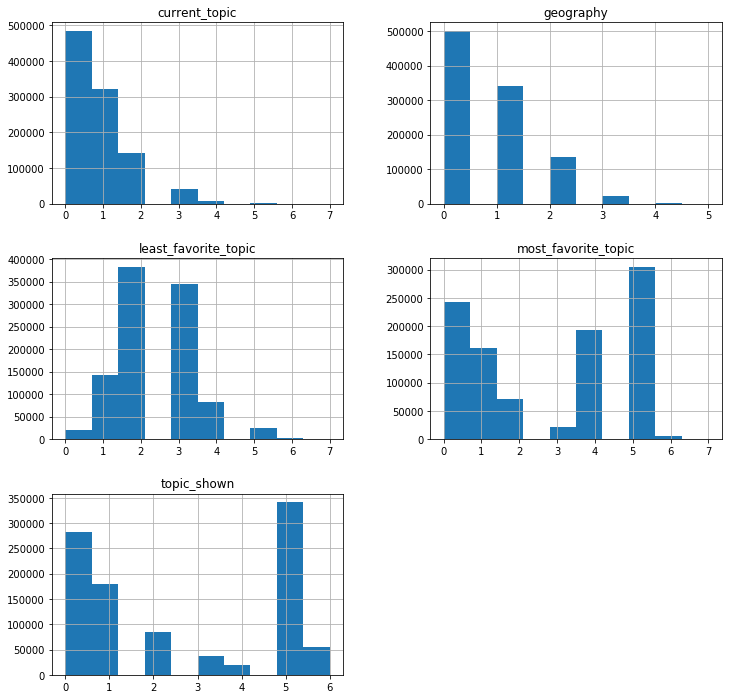

In [7]:
df.drop(['id', 'visit_count_30_days'], axis=1).replace(
    {v: k for k, v in topics.items()}
).replace(
    {v: k for k, v in geographies.items()}
).astype(int).hist(figsize=(12, 12))

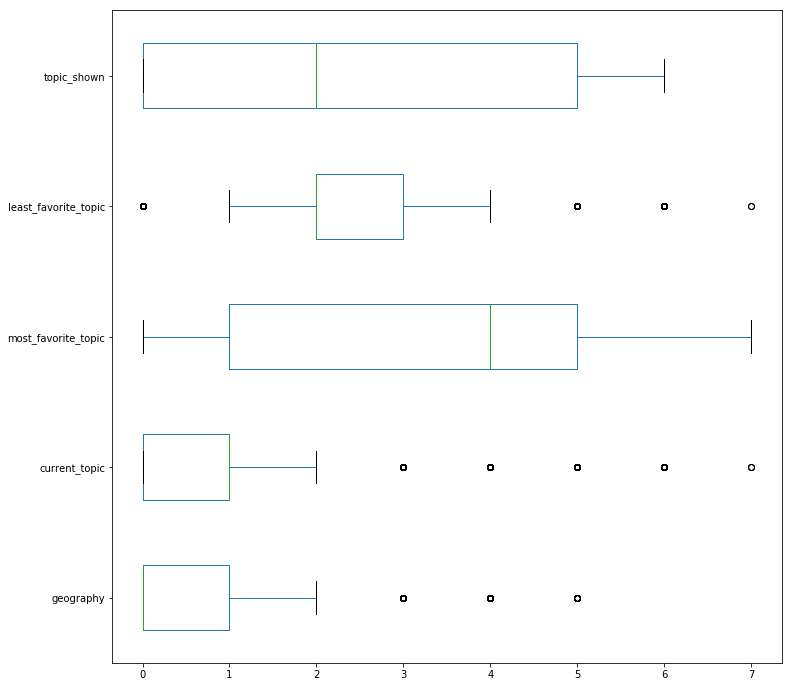

In [8]:
df.drop(['id', 'visit_count_30_days'], axis=1).replace(
    {v: k for k, v in topics.items()}
).replace(
    {v: k for k, v in geographies.items()}
).astype(int).plot.box(vert=False, figsize=(12, 12))

![scatter](scatter_matrix.png)

# Turn into a binary classification problem

We want to ensure that everyone is seeing articles from the topic _Opinion_ so we will turn this into a binary classification problem by changing the dataset.

In [9]:
for col in df.filter(regex='topic'):
    df[col] = np.where(df[col] == 'Opinion', 'Opinion', 'Other')
    df[col] = df[col].astype('category')

## Is there unfairness in the data?

In [10]:
from IPython.display import Markdown, display

for geo in df.geography.unique():
    i = df[df.geography == geo]
    N = len(i)
    favorable_ratio = round((i.topic_shown == 'Opinion').mean()*100,2)
    display(Markdown(f"**{geo}** ( _N_ = {format(N, ',')} ) has a favorable outcome in {favorable_ratio}% of cases"))

**Region B** ( _N_ = 341,137 ) has a favorable outcome in 4.52% of cases

**Region A** ( _N_ = 500,394 ) has a favorable outcome in 6.67% of cases

**Region C** ( _N_ = 135,868 ) has a favorable outcome in 4.47% of cases

**Region D** ( _N_ = 21,277 ) has a favorable outcome in 4.39% of cases

**Region E** ( _N_ = 1,305 ) has a favorable outcome in 4.29% of cases

**Region F** ( _N_ = 19 ) has a favorable outcome in 5.26% of cases

We believe that _Region A_ is a privileged group. As seen by the Disparate Impact:

In [11]:
priv = df.geography == 'Region A'
(df[~priv].topic_shown == 'Opinion').mean() / (df[priv].topic_shown == 'Opinion').mean()

0.6751103557282909

# Build a naive model

In [12]:
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [13]:
def df_to_dataset(dataframe, weights=None, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('topic_shown').replace({'Opinion': 0, 'Other': 1}).astype(int)
    if weights is not None:
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels, weights))
    else:
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [14]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False)
test_ds = df_to_dataset(test, shuffle=False)

In [15]:
feature_columns = []

feature_columns.append(feature_column.numeric_column('visit_count_30_days'))

feature = feature_column.categorical_column_with_vocabulary_list('geography', list(geographies.values()))
onehot = feature_column.indicator_column(feature)
feature_columns.append(onehot)

topic_features = ['current_topic', 'most_favorite_topic', 'least_favorite_topic']
for t in topic_features:
    feature = feature_column.categorical_column_with_vocabulary_list(t, ['Opinion', 'Other'])
    onehot = feature_column.indicator_column(feature)
    feature_columns.append(onehot)

We will return to this model later.

# Fairness Preprocessing

Notice that we are creating this the AIF360 `BinaryLabelDataset` using only the training data.

In [17]:
from aif360.datasets import BinaryLabelDataset
ai360df = BinaryLabelDataset(df=train.drop(['id'], axis=1).replace(
    {'Opinion': 0, 'Other': 1}
).replace(
    {v: k for k, v in geographies.items()}
).astype(int), label_names=['topic_shown'], protected_attribute_names=['geography'],
    unprivileged_protected_attributes=['Region B', 'Region C', 'Region D', 'Region E'])

In [18]:
unprivileged_groups, privileged_groups = [{'geography': 1}, {'geography': 2}, {'geography': 3}, {'geography': 4}, {'geography': 5}], [{'geography': 0}]

### Reweighing the dataset

By reweighing the dataset we reduce the disparate impact (DI) to 1. Notice that DI can be accessed in AIF360.

In [19]:
from aif360.algorithms.preprocessing import Reweighing
rw = Reweighing(unprivileged_groups, privileged_groups)
rw.fit(ai360df)
ai360df_rw = rw.transform(ai360df)

In [20]:
from aif360.metrics import BinaryLabelDatasetMetric
metric_df_rw = BinaryLabelDatasetMetric(ai360df_rw, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

display(Markdown("**Disparate Impact**"))
print(metric_df_rw.disparate_impact())

display(Markdown("**Statistical Parity Difference**"))
print(metric_df_rw.statistical_parity_difference())

display(Markdown("**Mean Difference**"))
print(metric_df_rw.mean_difference())

**Disparate Impact**

0.9999999999999994


**Statistical Parity Difference**

-5.551115123125783e-16


**Mean Difference**

-5.551115123125783e-16


The `instance_weights` assigns a weight to each sample.

In [21]:
print(ai360df_rw.instance_weights.shape, train.shape)
weights = ai360df_rw.instance_weights

(640000,) (640000, 7)


### Training on the reweighted dataset

Notice that we call `tf.keras.Sequential.fit` with the `ai360df_rw.instance_weights`.

# Comparing the models

In [32]:
model.load_weights("naive-checkpoints/weights.03-0.21.hdf5")
loss_naive, accuracy_naive = model.evaluate(test_ds)

6250/6250 [==============================] - 518s 83ms/step - loss: 0.2164 - accuracy: 0.9433


In [33]:
model.load_weights("weighted-checkpoints/weights.03-0.21.hdf5")
loss_weighted, accuracy_weighted = model.evaluate(test_ds)

6250/6250 [==============================] - 553s 88ms/step - loss: 0.2184 - accuracy: 0.9433


In [35]:
display(Markdown("**Naive model accuracy**"))
print(accuracy_naive)

display(Markdown("**Weighted model accuracy**"))
print(accuracy_weighted)

**Naive model accuracy**

0.94332


**Weighted model accuracy**

0.943315


In [37]:
idx = test.geography == 'Region A'
test_ds = df_to_dataset(test[idx], shuffle=False)

model.load_weights("naive-checkpoints/weights.03-0.21.hdf5")
loss_naive, accuracy_naive = model.evaluate(test_ds)

model.load_weights("weighted-checkpoints/weights.03-0.21.hdf5")
loss_weighted, accuracy_weighted = model.evaluate(test_ds)

display(Markdown("**Naive model accuracy for protected group**"))
print(accuracy_naive)

display(Markdown("**Weighted model accuracy for protected group**"))
print(accuracy_weighted)

3121/3121 [==============================] - 285s 91ms/step - loss: 0.2541 - accuracy: 0.9313


**Naive model accuracy for protected group**

0.9313214


**Weighted model accuracy for protected group**

0.9313214


In [38]:
test_ds = df_to_dataset(test[~idx], shuffle=False)

model.load_weights("naive-checkpoints/weights.03-0.21.hdf5")
loss_naive, accuracy_naive = model.evaluate(test_ds)

model.load_weights("weighted-checkpoints/weights.03-0.21.hdf5")
loss_weighted, accuracy_weighted = model.evaluate(test_ds)

display(Markdown("**Naive model accuracy for unprotected group**"))
print(accuracy_naive)

display(Markdown("**Weighted model accuracy for unprotected group**"))
print(accuracy_weighted)

3130/3130 [==============================] - 278s 89ms/step - loss: 0.1827 - accuracy: 0.9553


**Naive model accuracy for unprotected group**

0.9552877


**Weighted model accuracy for unprotected group**

0.9552777
